In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paddy-disease-classification/sample_submission.csv
/kaggle/input/paddy-disease-classification/train.csv
/kaggle/input/paddy-disease-classification/train_images/tungro/109629.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/104765.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/109706.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/100098.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102734.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/106433.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108930.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102019.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102416.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/101046.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108310.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/10402

In [2]:
from fastai.vision.all import *

In [3]:
path = os.getcwd()
train_path = path + '/sml'
print(train_path)

/kaggle/working/sml


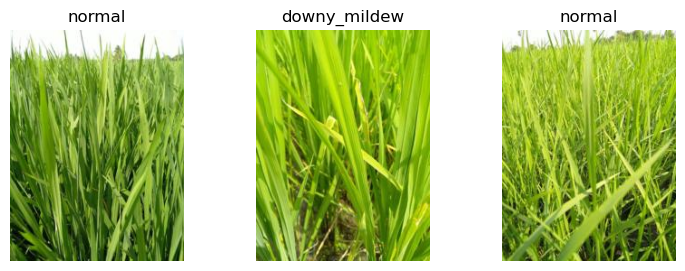

In [4]:
resize_images('/kaggle/input/paddy-disease-classification/train_images', dest=train_path, max_size=256, recurse=True)
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In [5]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [6]:
learn = train('resnet26d', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.924326,1.512031,0.460356,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.267300,0.937259,0.309947,00:37
1,1.016353,0.665672,0.212878,00:36
2,0.726009,0.465397,0.143681,00:37
3,0.529749,0.368238,0.111485,00:37
4,0.417183,0.360367,0.102835,00:37


In [7]:
arch = 'convnext_small_in22k'
learn = train(arch, item=Resize(192, method='squish'),batch=aug_transforms(size=128, min_scale=0.75))

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.280781,0.820916,0.263335,03:27


epoch,train_loss,valid_loss,error_rate,time
0,0.650967,0.538789,0.175877,03:47
1,0.492206,0.374371,0.109563,03:47
2,0.313986,0.262289,0.074964,03:47
3,0.179197,0.193118,0.050457,03:46
4,0.123304,0.185912,0.049015,03:46


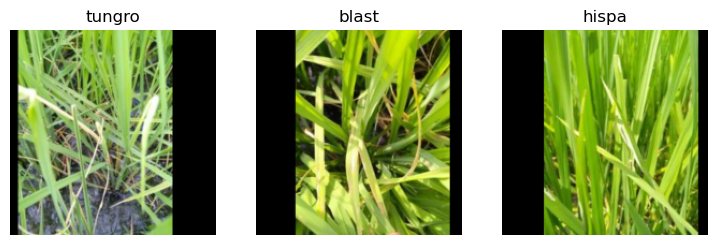

In [8]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [9]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.285900,0.882384,0.260452,03:35


epoch,train_loss,valid_loss,error_rate,time
0,0.651581,0.451589,0.146084,03:55
1,0.504970,0.394525,0.114849,03:55
2,0.342111,0.257093,0.075925,03:56
3,0.200226,0.191573,0.050937,03:55
4,0.137683,0.189594,0.049015,03:55


In [10]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [11]:
error_rate(preds, targs)

TensorBase(0.0490)

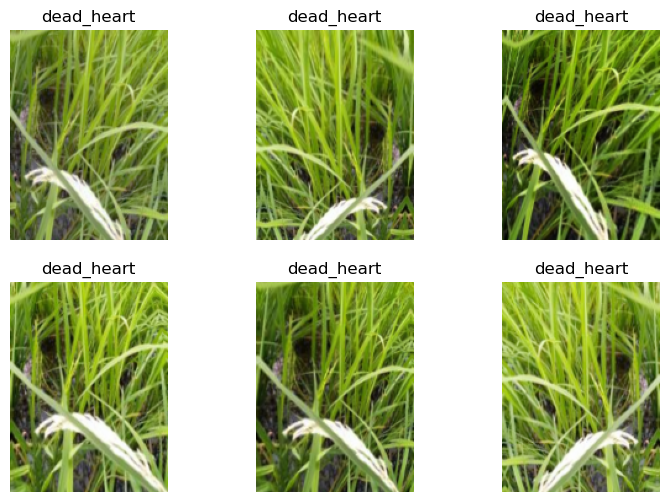

In [12]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [13]:
tta_preds,_ = learn.tta(dl=valid)

In [14]:
error_rate(tta_preds, targs)

TensorBase(0.0457)

In [16]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.216136,0.702039,0.218645,04:46


epoch,train_loss,valid_loss,error_rate,time
0,0.592400,0.352388,0.111004,05:22
1,0.461073,0.307643,0.098030,05:22
2,0.377365,0.385721,0.104757,05:18
3,0.304272,0.344771,0.095147,05:22
4,0.242644,0.231352,0.069197,05:24
5,0.188828,0.211455,0.058626,05:21
6,0.119628,0.159078,0.042287,05:23
7,0.093749,0.165321,0.038924,05:17
8,0.070369,0.168036,0.035560,05:13
9,0.049543,0.171697,0.031235,05:13


In [17]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0322)

In [18]:
tst_files = get_image_files('/kaggle/input/paddy-disease-classification/test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [19]:
preds,_ = learn.tta(dl=tst_dl)

In [20]:
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [23]:
ss = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')
ss['label'] = results
ss.to_csv('20250530_full_convnext_tta.csv', index=False)
# Walkthrough fast.ai course: part 2 and 3 convnext with tta
!head 20250530_full_convnext_tta.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


scored **0.96774** private

part 3 ok (additional small optimizations)